In [5]:
import pandas as pd
import os
import os.path as op
import arviz as az
from bauer.models import PsychometricModel

from tms_risk.utils.data import get_all_behavior
from tms_risk.cogmodels.fit_probit import build_model, get_data
import numpy as np
import pingouin as pg
from tms_risk.cogmodels.utils import extract_intercept_gamma, format_bambi_ppc, plot_ppc
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

bids_folder = '/data/ds-tmsrisk'

In [18]:
df = get_all_behavior(bids_folder=bids_folder, all_tms_conditions=True, exclude_outliers=True)
df = df.drop('baseline', level='stimulation_condition')
map_pars = pd.read_csv(op.join(bids_folder, 'derivatives', 'map_models', 'psychometric_simple.csv'), index_col=['subject', 'stimulation_condition'])
map_pars['gamma'] = 1./(2*np.sqrt(map_pars['nu']))
map_pars['rnp'] = np.exp(map_pars['bias'])


idata = az.from_netcdf(op.join(bids_folder, 'derivatives', 'cogmodels', 'model-probit_simple_trace.netcdf'))
data = get_data('probit_simple', bids_folder)
model = build_model('probit_simple', data)
intercept, gamma = extract_intercept_gamma(idata, model, data, group=False)
intercept = intercept.stack([1, 2], future_stack=True)['intercept']
gamma = gamma.stack([1, 2], future_stack=True)['gamma']

rnp = np.exp(intercept/gamma).rename('rnp')
bayesian_pars = rnp.groupby(['subject', 'stimulation_condition']).mean().to_frame().join(gamma.groupby(['subject', 'stimulation_condition']).mean())


Dropping the baseline condition


# Preference versus consistency

,n,r,CI95%,p-val,BF10,power
pearson,35,0.756129,"[0.57, 0.87]",1.497074e-07,1.157e+05,0.999885


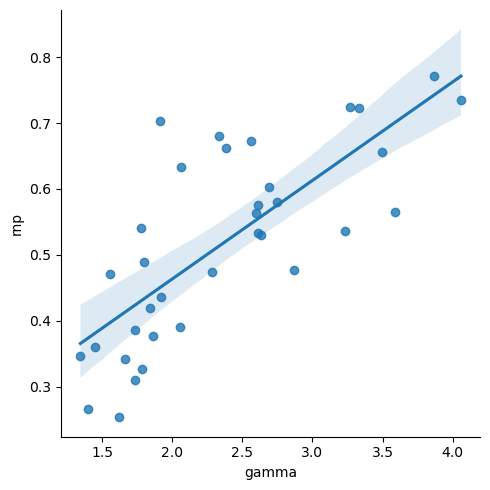

In [8]:
sns.lmplot(x='gamma', y='rnp', data=bayesian_pars.groupby(['subject']).mean().reset_index())

tmp = bayesian_pars.groupby(['subject']).mean().reset_index()

pg.corr(x=tmp['gamma'], y=tmp['rnp'])

# Difference in preference versus conistency

,n,r,CI95%,p-val,BF10,power
pearson,35,-0.161284,"[-0.47, 0.18]",0.354657,0.317,0.153395


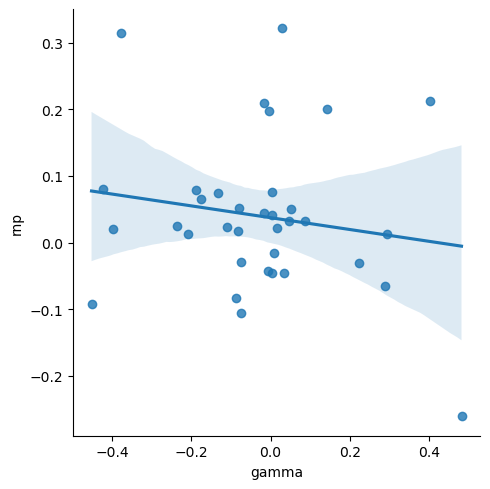

In [19]:
diff = map_pars.stack().unstack('stimulation_condition')

diff = (diff['ips'] - diff['vertex']).unstack()

sns.lmplot(x='gamma', y='rnp', data=diff.reset_index())

display(pg.corr(x=diff['gamma'], y=diff['rnp']))

In [15]:
diff

,rnp,gamma
subject,,
1,0.043735,-0.093679
2,0.036258,-0.204940
3,0.022477,-0.294282
4,-0.030643,-0.362749
5,0.037365,-0.179308
6,0.047461,-0.033720
7,0.031835,-0.410567
9,0.127079,0.265239
10,0.045062,-0.182359


# Order model

In [32]:
df = get_all_behavior(bids_folder=bids_folder, all_tms_conditions=True, exclude_outliers=True)
df = df.drop('baseline', level='stimulation_condition')
map_pars = pd.read_csv(op.join(bids_folder, 'derivatives', 'map_models', 'psychometric_order.csv'), index_col=['subject', 'stimulation_condition', 'risky_first'])
map_pars['gamma'] = 1./(2*np.sqrt(map_pars['nu']))
map_pars['rnp'] = np.exp(map_pars['bias'])

idata = az.from_netcdf(op.join(bids_folder, 'derivatives', 'cogmodels', 'model-probit_order_trace.netcdf'))
data = get_data('probit_order', bids_folder)
model = build_model('probit_order', data)
intercept, gamma = extract_intercept_gamma(idata, model, data, group=False)
intercept = intercept.stack([1, 2], future_stack=True)['intercept']
gamma = gamma.stack([1, 2], future_stack=True)['gamma']

bayesian_pars = intercept.groupby(['subject', 'stimulation_condition', 'risky_first']).mean().to_frame().join(gamma.groupby(['subject', 'stimulation_condition']).mean())
bayesian_pars['rnp'] = np.exp(bayesian_pars['intercept']/bayesian_pars['gamma']).rename('rnp')

bayesian_pars['distance_to_rnp'] = (bayesian_pars['rnp'] - .55).abs()

Dropping the baseline condition


In [34]:
pg.corr?

Signature: pg.corr(x, y, alternative='two-sided', method='pearson', **kwargs)
Docstring:
(Robust) correlation between two variables.

Parameters
----------
x, y : array_like
    First and second set of observations. ``x`` and ``y`` must be
    independent.
alternative : string
    Defines the alternative hypothesis, or tail of the correlation. Must be one of
    "two-sided" (default), "greater" or "less". Both "greater" and "less" return a one-sided
    p-value. "greater" tests against the alternative hypothesis that the correlation is
    positive (greater than zero), "less" tests against the hypothesis that the correlation is
    negative.
method : string
    Correlation type:

    * ``'pearson'``: Pearson :math:`r` product-moment correlation
    * ``'spearman'``: Spearman :math:`\rho` rank-order correlation
    * ``'kendall'``: Kendall's :math:`\tau_B` correlation (for ordinal data)
    * ``'bicor'``: Biweight midcorrelation (robust)
    * ``'percbend'``: Percentage bend correlation

,,n,r,CI95%,p-val,BF10,power
risky_first,,,,,,,
False,pearson,35,-0.328518,"[-0.6, 0.01]",0.054003,1.252,0.497444
True,pearson,35,-0.594447,"[-0.77, -0.33]",0.000166,189.276,0.974878


,n,r,CI95%,p-val,BF10,power
pearson,35,-0.510759,"[-1.0, -0.27]",0.000859,47.041,0.943887


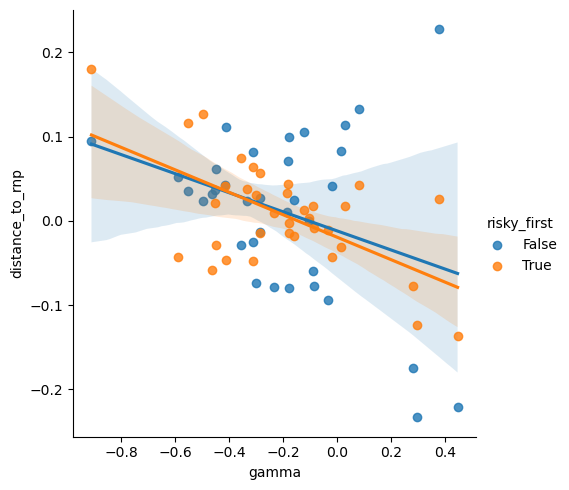

In [36]:
diff = bayesian_pars.stack().unstack('stimulation_condition')

diff = (diff['ips'] - diff['vertex']).unstack()

sns.lmplot(x='gamma', y='distance_to_rnp', data=diff.reset_index(), hue='risky_first')

display(diff.groupby('risky_first').apply(lambda x: pg.corr(x['gamma'], x['distance_to_rnp'], alternative='two-sided')))


tmp = diff.groupby(['subject']).mean()

pg.corr(x=tmp['gamma'], y=tmp['distance_to_rnp'], alternative='less')